This file is to reproduce the CPAR model in our paper.

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from sdv.metadata import SingleTableMetadata
from sdv.evaluation.single_table import evaluate_quality
from sdv.single_table import CTGANSynthesizer
from sdv.evaluation.single_table import get_column_plot
from sdv.sequential import PARSynthesizer
import seaborn as sns
from collections import Counter
from matplotlib.patches import Patch
from functions import *

import os
import random
import torch

from IPython.display import display, HTML

## 0.0 Preprocessing

In [2]:
# load the wide format dataset
df_wide = pd.read_csv('..\\01_data\\PIAAC_mergedata_U21_collapsed_all.csv')
df_wide.drop(columns=['Unnamed: 0'], inplace=True)
df_wide_original = df_wide.copy()
df_wide["ActionSeq_Collapsed"] = df_wide["ActionSeq_Collapsed"].apply(lambda x: x.replace("START,", "").replace(",END", ""))
# drop the row whose ID is in 1830, 4077, 4450, 7519, 201992, because they are not ended with "END".
df_wide = df_wide[~df_wide['ID'].isin([1830, 4077, 4450, 7519, 201992])].reset_index(drop=True)

In [3]:
# create a new df object to store the converted long format df
df_long = pd.DataFrame(columns=df_wide.columns)

col_index = 0
for i in range(df_wide.shape[0]):

    # remove the START and END tokens
    act_seq_i = df_wide["ActionSeq_Collapsed"][i].split(",")[1: -1]

    # get the length of the sequence
    act_seq_len = len(act_seq_i)

    # create the updated df_tempt to be concatenated to df_long
    df_tempt = pd.DataFrame([df_wide.iloc[i]] * act_seq_len, columns=df_wide.columns)

    # change  the df_tmp["ActionSeq_Collapsed"] values to be act_seq_i
    df_tempt["ActionSeq_Collapsed"] = act_seq_i

    # add a new column to df_tempt to store the sequence index
    df_tempt["Seq_Index"] = list(range(act_seq_len))

    # make the ith row of df_wide to repeat for act_seq_len times
    df_long = pd.concat([df_long, df_tempt], ignore_index=True)

# change the Seq_Index column to be integer
df_long["Seq_Index"] = df_long["Seq_Index"].astype(int)

C:\Users\grepa\AppData\Local\Temp\ipykernel_20612\3075704666.py:23: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_long = pd.concat([df_long, df_tempt], ignore_index=True)
C:\Users\grepa\AppData\Local\Temp\ipykernel_20612\3075704666.py:23: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_long = pd.concat([df_long, df_tempt], ignore_index=True)
C:\Users\grepa\AppData\Local\Temp\ipykernel_20612\3075704666.py:23: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries 

In [4]:
# convert the AS_index into a datetime object
df_long['Seq_Index'] = pd.to_datetime('2000-01-01') + pd.to_timedelta(df_long['Seq_Index'], unit='d')
# change the ActionSeq_Collapsed column's name into Action
df_long.rename(columns={"ActionSeq_Collapsed": "Action"}, inplace=True)

In [5]:
# change the ActionCount, GradedScore, ResponseTime, LiteracyScore, NumeracyScore to be float
df_long["ActionCount"] = df_long["ActionCount"].astype(float)
df_long["GradedScore"] = df_long["GradedScore"].astype(float)
df_long["ResponseTime"] = df_long["ResponseTime"].astype(float)
df_long["LiteracyScore"] = df_long["LiteracyScore"].astype(float)
df_long["NumeracyScore"] = df_long["NumeracyScore"].astype(float)

In [6]:
df_long.head()

,ID,AgeGroup,Gender,ActionCount,Action,GradedScore,ResponseTime,LiteracyScore,NumeracyScore,Country,Seq_Index
0,13,40-44,Male,23.0,TAB,1.0,213294.0,304.22325,284.13901,UK,2000-01-01
1,13,40-44,Male,23.0,COMBOBOX,1.0,213294.0,304.22325,284.13901,UK,2000-01-02
2,13,40-44,Male,23.0,COMBOBOX,1.0,213294.0,304.22325,284.13901,UK,2000-01-03
3,13,40-44,Male,23.0,BUTTON,1.0,213294.0,304.22325,284.13901,UK,2000-01-04
4,13,40-44,Male,23.0,TAB,1.0,213294.0,304.22325,284.13901,UK,2000-01-05


In [7]:
from rdt.transformers.categorical import UniformEncoder, LabelEncoder, OneHotEncoder, OrderedUniformEncoder
from rdt.transformers.text import IDGenerator
from rdt.transformers.numerical import FloatFormatter
from rdt import HyperTransformer

C:\Users\grepa\AppData\Local\Temp\ipykernel_20612\2971138474.py:2: DeprecationWarning: Importing 'IDGenerator' or 'RegexGenerator' for ID columns from 'rdt.transformers.text' is deprecated. Please use 'rdt.transformers.id' instead.
  from rdt.transformers.text import IDGenerator


In [8]:
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(df_long)
# revise the metadata
metadata.update_column(
    column_name='GradedScore',
    sdtype='numerical'
)
metadata.update_column(
    column_name='ID',
    sdtype='id'
)
metadata

{
    "columns": {
        "ID": {
            "sdtype": "id"
        },
        "AgeGroup": {
            "sdtype": "categorical"
        },
        "Gender": {
            "sdtype": "categorical"
        },
        "ActionCount": {
            "sdtype": "numerical"
        },
        "Action": {
            "sdtype": "categorical"
        },
        "GradedScore": {
            "sdtype": "numerical"
        },
        "ResponseTime": {
            "sdtype": "numerical"
        },
        "LiteracyScore": {
            "sdtype": "numerical"
        },
        "NumeracyScore": {
            "sdtype": "numerical"
        },
        "Country": {
            "sdtype": "categorical"
        },
        "Seq_Index": {
            "sdtype": "datetime"
        }
    },
    "METADATA_SPEC_VERSION": "SINGLE_TABLE_V1"
}

In [9]:
metadata.set_sequence_key(column_name='ID')
metadata.set_sequence_index(column_name='Seq_Index')

In [10]:
# set the random seed
# Set the seed for CPU and GPU computations
def set_seed(seed):
    # Set the seed for Python's built-in random module
    random.seed(seed)
    
    # Set the seed for NumPy
    np.random.seed(seed)
    
    # Set the seed for PyTorch (both CPU and GPU)
    torch.manual_seed(seed)  # For CPU
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)  # For current GPU
        torch.cuda.manual_seed_all(seed)  # For all GPUs (if using multiple)
    
    # Optionally, ensure deterministic behavior (this may impact performance)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(666)

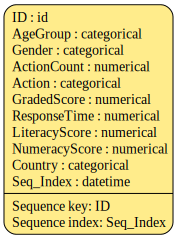

In [11]:
metadata.visualize()

## 1.0 PAR model building

In [12]:
# the context colulmns are those do not varied within the same ID
synthesizer = PARSynthesizer(metadata,
                             context_columns=['AgeGroup','Gender','ActionCount', 'GradedScore','ResponseTime','LiteracyScore','NumeracyScore','Country'],
                             #context_columns=['AgeGroup','Gender','ActionCount', 'GradedScore','ResponseTime','LiteracyScore','Country'],
                             cuda=True,
                             enforce_min_max_values=True,
                             enforce_rounding=True,
                             verbose=True,
                             epochs=185)

synthesizer.auto_assign_transformers(df_long)
synthesizer.get_transformers()

c:\Users\grepa\anaconda3\envs\deepml\Lib\site-packages\sdv\single_table\base.py:145: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
c:\Users\grepa\anaconda3\envs\deepml\Lib\site-packages\sdv\single_table\base.py:123: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


{'ID': None,
 'AgeGroup': None,
 'Gender': None,
 'ActionCount': None,
 'Action': None,
 'GradedScore': None,
 'ResponseTime': None,
 'LiteracyScore': None,
 'NumeracyScore': None,
 'Country': None,
 'Seq_Index': UnixTimestampEncoder()}

Note: If you want to run and test the CTGAN training process, please remove the comment signs. To reproduce our results, please directly load our trained model.

In [13]:
# synthesizer.fit(data = df_long)

In [13]:
# synthesizer.save('../03_output_PAN/trained_model/27_sequential_seed666_185Epoch_241214.pkl')
synthesizer = PARSynthesizer.load('../03_outputs/trained_models/CPAR_trained.pkl')

c:\Users\grepa\anaconda3\envs\deepml\Lib\site-packages\sdv\_utils.py:291: SDVVersionWarning: You are currently on SDV version 1.21.0 but this synthesizer was created on version 1.16.2. The latest bug fixes and features may not be available for this synthesizer. To see these enhancements, create and train a new synthesizer on this version.
  warnings.warn(message, SDVVersionWarning)


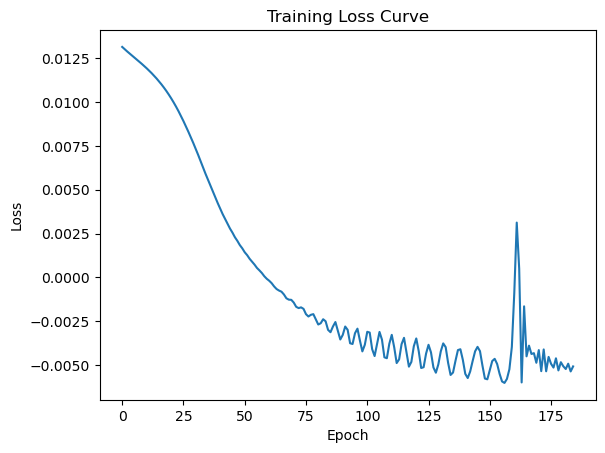

In [14]:
loss_values = synthesizer.get_loss_values()
# plot the loss values df, where the first column is the epoch and the second column is the loss value
plt.plot(loss_values['Epoch'], loss_values['Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.show()

In [15]:
synthesizer._model._ctx_map

{0: {'type': 'categorical',
  'indices': {'20-24': 1,
   '50-54': 2,
   '35-39': 3,
   '60-65': 4,
   '55-59': 5,
   '30-34': 6,
   '45-49': 7,
   '40-44': 8,
   '25-29': 9,
   '16-19': 10}},
 1: {'type': 'categorical', 'indices': {'Female': 12, 'Male': 13}},
 2: {'type': 'continuous',
  'mu': 23.305755395683452,
  'std': 9.38332571148389,
  'nulls': False,
  'indices': (14, 15, 16)},
 3: {'type': 'continuous',
  'mu': 2.854807063440157,
  'std': 3.0615836457521497,
  'nulls': False,
  'indices': (17, 18, 19)},
 4: {'type': 'continuous',
  'mu': 209439.7115761936,
  'std': 103855.109738802,
  'nulls': False,
  'indices': (20, 21, 22)},
 5: {'type': 'continuous',
  'mu': 278.0200281229562,
  'std': 42.91641462559645,
  'nulls': False,
  'indices': (23, 24, 25)},
 6: {'type': 'continuous',
  'mu': 266.6711612459124,
  'std': 47.51844876169171,
  'nulls': False,
  'indices': (26, 27, 28)},
 7: {'type': 'categorical', 'indices': {'UK': 30, 'US': 31}},
 8: {'type': 'continuous',
  'mu': 9.4

Note, the sampling method is based on the unique ID rather than the specific row, which means if you wanna have 3000 observations, just sampling for 3000 is ok.

In [16]:
# check the unique number of ID in df_wide
df_wide['ID'].nunique()

3249

## 2.0 Post-processing

You can generate the synthetic data here. To reproduce our results, please load the saved synthetic sanple as follows.

In [ ]:
# sd = synthesizer.sample(df_wide['ID'].nunique())
# save the generated data
# sd.to_csv('../03_output_PAN/27_generated_3429_185_epoch_data.csv', index=False)

In [17]:
# load the generated data
sd = pd.read_csv('../03_outputs/CPAR_synthetic_sample.csv')

In [19]:
sd.iloc[:10]

,ID,AgeGroup,Gender,ActionCount,Action,GradedScore,ResponseTime,LiteracyScore,NumeracyScore,Country,Seq_Index
0,461225945,45-49,Female,8.0,KEYPRESS,0.0,257640.0,217.01082,197.58702,US,2000-01-01
1,461225945,45-49,Female,8.0,TAB,0.0,257640.0,217.01082,197.58702,US,2000-01-02
2,461225945,45-49,Female,8.0,TOOLBAR_HISTORY_BACK,0.0,257640.0,217.01082,197.58702,US,2000-01-03
3,461225945,45-49,Female,8.0,BUTTON,0.0,257640.0,217.01082,197.58702,US,2000-01-04
4,461225945,45-49,Female,8.0,BUTTON,0.0,257640.0,217.01082,197.58702,US,2000-01-05
5,461225945,45-49,Female,8.0,TEXTBOX_ONFOCUS,0.0,257640.0,217.01082,197.58702,US,2000-01-06
6,461225945,45-49,Female,8.0,CHECKBOX,0.0,257640.0,217.01082,197.58702,US,2000-01-07
7,461225945,45-49,Female,8.0,COMBOBOX,0.0,257640.0,217.01082,197.58702,US,2000-01-08
8,461225945,45-49,Female,8.0,TAB,0.0,257640.0,217.01082,197.58702,US,2000-01-09
9,461225945,45-49,Female,8.0,TAB,0.0,257640.0,217.01082,197.58702,US,2000-01-10


### 2.1 convert back the wide format

In [20]:
# convert the long format data into wide format
# Collapse the data by ID
sd_back = (
    sd.groupby("ID")
    .agg({
        'AgeGroup': 'first',  # Take the first value (same for each ID)
        'Gender': 'first',
        #'AS_Index': 'first',
        'ActionCount': 'first',
        'Action': lambda x: ','.join(x),  # Convert ActionSeq to a list of actions
        'GradedScore': 'first',
        'ResponseTime': 'first',
        'LiteracyScore': 'first',
        'NumeracyScore': 'first',
        'Country': 'first'
    })
    .reset_index()
)

# Display the first few rows of the collapsed data
sd_back.head()

,ID,AgeGroup,Gender,ActionCount,Action,GradedScore,ResponseTime,LiteracyScore,NumeracyScore,Country
0,109271,16-19,Female,15.0,"BUTTON,TEXTBOX_ONFOCUS,CHECKBOX,CHECKBOX,BUTTO...",1.0,190643.0,282.09454,259.05472,US
1,332462,45-49,Male,12.0,"CHECKBOX,CHECKBOX,COMBOBOX,COMBOBOX,TEXTBOX_ON...",2.0,286853.0,256.45478,252.64343,UK
2,895311,40-44,Male,21.0,"TAB,TEXTBOX_ONFOCUS,TAB,TAB,TAB,BUTTON,BUTTON,...",1.0,438673.0,307.47876,327.71507,UK
3,917145,45-49,Female,24.0,"BUTTON,TAB,TAB,CHECKBOX,TEXTBOX_ONFOCUS,TEXTBO...",5.0,281400.0,288.66613,256.43882,UK
4,1123281,50-54,Female,39.0,"COMBOBOX,BUTTON,CHECKBOX,CHECKBOX,BUTTON,BUTTO...",2.0,225327.0,224.41227,266.47432,UK


In [21]:
# add START and END tokens to the Action column
sd_back['Action'] = sd_back['Action'].apply(lambda x: 'START,' + x + ', END')
sd_back.head()

,ID,AgeGroup,Gender,ActionCount,Action,GradedScore,ResponseTime,LiteracyScore,NumeracyScore,Country
0,109271,16-19,Female,15.0,"START,BUTTON,TEXTBOX_ONFOCUS,CHECKBOX,CHECKBOX...",1.0,190643.0,282.09454,259.05472,US
1,332462,45-49,Male,12.0,"START,CHECKBOX,CHECKBOX,COMBOBOX,COMBOBOX,TEXT...",2.0,286853.0,256.45478,252.64343,UK
2,895311,40-44,Male,21.0,"START,TAB,TEXTBOX_ONFOCUS,TAB,TAB,TAB,BUTTON,B...",1.0,438673.0,307.47876,327.71507,UK
3,917145,45-49,Female,24.0,"START,BUTTON,TAB,TAB,CHECKBOX,TEXTBOX_ONFOCUS,...",5.0,281400.0,288.66613,256.43882,UK
4,1123281,50-54,Female,39.0,"START,COMBOBOX,BUTTON,CHECKBOX,CHECKBOX,BUTTON...",2.0,225327.0,224.41227,266.47432,UK


In [22]:
# change the ActionCount into actual count
action_count_list = []

for seq in sd_back['Action']:
    # split the sequence by ','
    seq_split = seq.split(',')
    # count the number of actions
    action_count = len(seq_split)
    # append the action count to the list
    action_count_list.append(action_count)

sd_back["ActionCount"] = action_count_list
sd_back.head()

,ID,AgeGroup,Gender,ActionCount,Action,GradedScore,ResponseTime,LiteracyScore,NumeracyScore,Country
0,109271,16-19,Female,10,"START,BUTTON,TEXTBOX_ONFOCUS,CHECKBOX,CHECKBOX...",1.0,190643.0,282.09454,259.05472,US
1,332462,45-49,Male,10,"START,CHECKBOX,CHECKBOX,COMBOBOX,COMBOBOX,TEXT...",2.0,286853.0,256.45478,252.64343,UK
2,895311,40-44,Male,27,"START,TAB,TEXTBOX_ONFOCUS,TAB,TAB,TAB,BUTTON,B...",1.0,438673.0,307.47876,327.71507,UK
3,917145,45-49,Female,22,"START,BUTTON,TAB,TAB,CHECKBOX,TEXTBOX_ONFOCUS,...",5.0,281400.0,288.66613,256.43882,UK
4,1123281,50-54,Female,56,"START,COMBOBOX,BUTTON,CHECKBOX,CHECKBOX,BUTTON...",2.0,225327.0,224.41227,266.47432,UK


In [23]:
metadata_test = SingleTableMetadata()
metadata_test.detect_from_dataframe(sd_back)
metadata_test

{
    "columns": {
        "ID": {
            "sdtype": "id"
        },
        "AgeGroup": {
            "sdtype": "categorical"
        },
        "Gender": {
            "sdtype": "categorical"
        },
        "ActionCount": {
            "sdtype": "numerical"
        },
        "Action": {
            "sdtype": "categorical"
        },
        "GradedScore": {
            "sdtype": "categorical"
        },
        "ResponseTime": {
            "sdtype": "numerical"
        },
        "LiteracyScore": {
            "sdtype": "numerical"
        },
        "NumeracyScore": {
            "sdtype": "numerical"
        },
        "Country": {
            "sdtype": "categorical"
        }
    },
    "primary_key": "ID",
    "METADATA_SPEC_VERSION": "SINGLE_TABLE_V1"
}

In [24]:
metadata_test.update_column(
    column_name='GradedScore',
    sdtype='numerical'
)

metadata_test.update_column(
    column_name='Action',
    sdtype='categorical'
)

df_wide.rename(columns={"ActionSeq_Collapsed": "Action"}, inplace=True)

## 3.0 Check the quality scores

In [25]:
# Quality Score
quality_report1 = evaluate_quality(df_wide, sd_back, metadata_test)

# Retrieve details for column shapes
quality_deets1 = quality_report1.get_details(property_name='Column Shapes')

print(quality_deets1)

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 10/10 [00:00<00:00, 63.00it/s]|
Column Shapes Score: 80.23%

(2/2) Evaluating Column Pair Trends: |██████████| 45/45 [00:00<00:00, 317.62it/s]|
Column Pair Trends Score: 61.76%

Overall Score (Average): 70.99%

          Column        Metric         Score
0       AgeGroup  TVComplement  9.692213e-01
1         Gender  TVComplement  9.996922e-01
2    ActionCount  KSComplement  7.226839e-01
3         Action  TVComplement  8.581094e-07
4    GradedScore  KSComplement  6.922130e-01
5   ResponseTime  KSComplement  9.424438e-01
6  LiteracyScore  KSComplement  9.532164e-01
7  NumeracyScore  KSComplement  9.535242e-01
8        Country  TVComplement  9.873807e-01


In [26]:
from sdmetrics.single_column import TVComplement
TVComplement.compute(real_data = df_long["Action"], synthetic_data = sd["Action"])

0.8953892814865927

In [27]:
from collections import Counter
from nltk import ngrams
from scipy.spatial.distance import jensenshannon

In [28]:
df_wide_original.rename(columns={"ActionSeq_Collapsed": "ActionSequence"}, inplace=True)
sd_back.rename(columns={"Action": "ActionSequence"}, inplace=True)

In [29]:
# drop the column ID
df_wide_original.drop(columns=['ID'], inplace=True)
sd_back.drop(columns=['ID'], inplace=True)

In [31]:
save_or_not = True

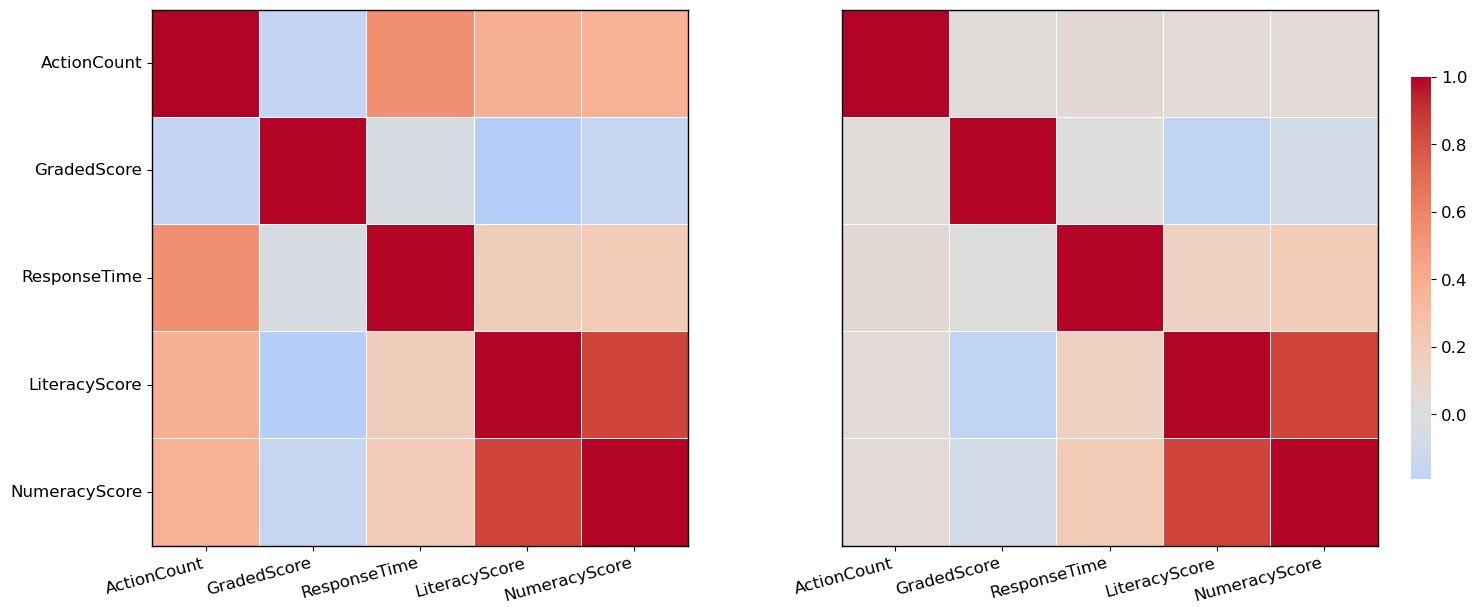

In [32]:
# transformed means the real data
corr_matrix_real = df_wide_original.drop(columns=['Country', 'Gender', 'AgeGroup', 'ActionSequence']).corr()
corr_matrix_fake = sd_back.drop(columns=['Country', 'Gender', 'AgeGroup', 'ActionSequence']).corr()

# Create a figure with two subplots side by side
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

# Plot the first correlation matrix on the left subplot
sns.heatmap(
    corr_matrix_real,
    annot=False,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    square=True,
    linewidths=0.5,
    # cbar_kws={"shrink": 0.75},
    cbar = False, # to remove the color bar
    ax=axes[0],  # Specify the Axes to plot on
    annot_kws={"size": 12} # Adjust the font size of the annotations
)
# axes[0].set_title("Correlation Matrix of Real Data", fontsize=16, pad=12)
axes[0].tick_params(axis='x', labelsize=12)
axes[0].tick_params(axis='y', labelsize=12)

axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=15, ha='right')
axes[0].set_yticklabels(axes[0].get_yticklabels(), ha='right')

# Plot the second correlation matrix on the right subplot
sns.heatmap(
    corr_matrix_fake,
    annot=False,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    square=True,
    linewidths=0.5,
    cbar=True, # to show the color bar
    cbar_kws={"shrink": 0.75}, # Adjust the color bar
    ax=axes[1],  # Specify the Axes to plot on
    annot_kws={"size": 12} # Adjust the font size of the annotations
).collections[0].colorbar.ax.tick_params(labelsize=12)

# axes[1].set_title("Correlation Matrix of Synthetic Data", fontsize=16, pad=12)
axes[1].tick_params(axis='x', labelsize=12)
axes[1].tick_params(axis='y', left = False, labelleft=False, labelsize=12)


axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=15, ha='right')
#axes[1].set_yticklabels(axes[1].get_yticklabels(), rotation=45, ha='right')

plt.subplots_adjust(wspace=1)

# Ensure that the frame is visible in both subplots:
for ax in axes:
    # Make sure the axes frame is turned on
    ax.set_frame_on(True)
    # Make the background patch transparent so the spines are visible on top
    ax.patch.set_visible(False)
    # Loop through each spine and set its properties
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_edgecolor('black')
        spine.set_linewidth(1.0)

# Adjust the layout so that the subplots do not overlap
plt.tight_layout()

# Save the figure if desired

if save_or_not:
    plt.savefig("../03_outputs/CPAR_corr_heat_map.png", dpi=600, bbox_inches='tight')

# Display the figure
plt.show()

In [33]:
metadata_test = SingleTableMetadata()
metadata_test.detect_from_dataframe(sd_back)
metadata_test.update_column(
    column_name='GradedScore',
    sdtype='numerical'
)

metadata_test.update_column(
    column_name='ActionSequence',
    sdtype='categorical'
)

In [34]:
# Quality Score
quality_report1 = evaluate_quality(df_wide_original, sd_back, metadata_test)

# Retrieve details for column shapes
quality_deets1 = quality_report1.get_details(property_name='Column Shapes')

print(quality_deets1)

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 9/9 [00:00<00:00, 42.06it/s]|
Column Shapes Score: 80.22%

(2/2) Evaluating Column Pair Trends: |██████████| 36/36 [00:00<00:00, 260.91it/s]|
Column Pair Trends Score: 61.77%

Overall Score (Average): 70.99%

           Column        Metric         Score
0        AgeGroup  TVComplement  9.692055e-01
1          Gender  TVComplement  9.999487e-01
2     ActionCount  KSComplement  7.226758e-01
3  ActionSequence  TVComplement  8.567908e-07
4     GradedScore  KSComplement  6.921607e-01
5    ResponseTime  KSComplement  9.425753e-01
6   LiteracyScore  KSComplement  9.528407e-01
7   NumeracyScore  KSComplement  9.532043e-01
8         Country  TVComplement  9.870671e-01


In [38]:
# get the score of generalization
from sdmetrics.single_table import NewRowSynthesis

general_score = NewRowSynthesis.compute(
    real_data = df_wide_original,
    synthetic_data = sd_back,
    metadata=metadata_test,
    numerical_match_tolerance=0.01,
    synthetic_sample_size=None,
)

In [39]:
general_score

1.0

C:\Users\grepa\AppData\Local\Temp\ipykernel_20612\3329288513.py:133: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_right.set_xticklabels(ax_right.get_xticklabels(), rotation=15, fontsize=font_size-4)


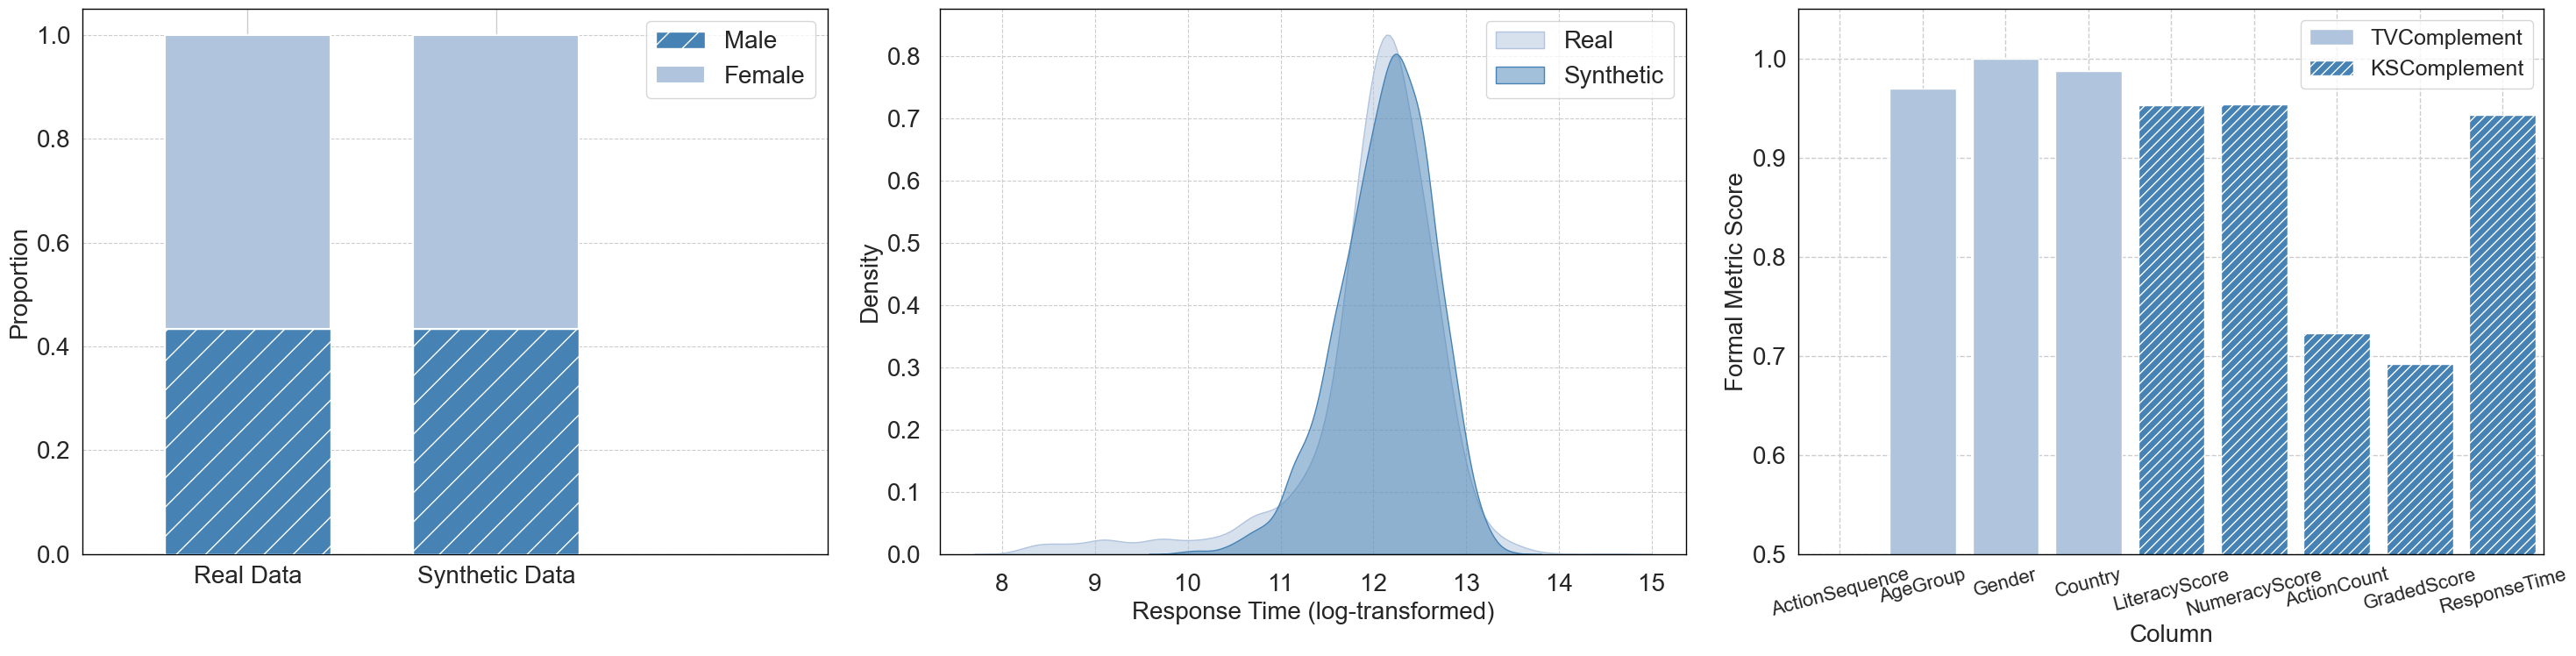

In [37]:
# =========================================================================
# 1) DATA PREPARATION (same as before)
# =========================================================================

font_size = 20

# ----------------------
# For the LEFT bar plot
# ----------------------
# Calculate normalized gender counts for real and synthetic data
real_counts = df_wide_original['Gender'].value_counts(normalize=True)
synth_counts = sd_back['Gender'].value_counts(normalize=True)

male_prop = real_counts.get('Male', 0)
female_prop = real_counts.get('Female', 0)
real_props = [male_prop, female_prop]

male_prop_synth = synth_counts.get('Male', 0)
female_prop_synth = synth_counts.get('Female', 0)
synth_props = [male_prop_synth, female_prop_synth]

# x positions for the two bars (closer together)
x = [-0.05, 0.10]

# -----------------------
# For the MIDDLE plot (Density)
# -----------------------
# Extract the ResponseTime column from synthetic and real data
response_fake = pd.DataFrame({"ResponseTime": sd_back['ResponseTime'], "Dataset": "Synthetic"})
response_real = pd.DataFrame({"ResponseTime": df_wide_original['ResponseTime'], "Dataset": "Real"})

# Log-transform the ResponseTime column
response_fake["ResponseTime"] = np.log1p(response_fake["ResponseTime"])
response_real["ResponseTime"] = np.log1p(response_real["ResponseTime"])

# -----------------------
# For the RIGHT bar plot
# -----------------------
# Suppose quality_deets1 has columns: Column, Metric, Score
# Define the custom order with "ActionSequence" as the first bar
custom_order = [
    "ActionSequence", "AgeGroup", "Gender", "Country", 
    "LiteracyScore", "NumeracyScore", "ActionCount", "GradedScore", "ResponseTime"
]

# Create a mapping from Column to Metric for later bar customization
metric_mapping = quality_deets1.set_index('Column')['Metric'].to_dict()

# =========================================================================
# 2) CREATE A SINGLE FIGURE WITH 3 SUBPLOTS (LEFT, MIDDLE, RIGHT)
# =========================================================================
fig, axes = plt.subplots(1, 3, figsize=(30, 8))  # adjust figsize as needed
ax_left, ax_middle, ax_right = axes

# =========================================================================
# LEFT SUBPLOT: Bar Plot (Gender Distribution)
# =========================================================================
ax_left.grid(axis='y', linestyle='--', linewidth=0.8, zorder=0)

# Plot the male part (base)
ax_left.bar(
    x, [real_props[0], synth_props[0]],
    color='steelblue', hatch='/', edgecolor='white',
    width=0.10, label='Male', zorder=3
)

# Plot the female part on top
ax_left.bar(
    x, [real_props[1], synth_props[1]],
    bottom=[real_props[0], synth_props[0]],
    color='lightsteelblue', width=0.10, linewidth=1.5,
    label='Female', zorder=3
)

# Customize x-axis, y-axis, etc.
ax_left.set_xticks(x)
ax_left.set_xticklabels(['Real Data', 'Synthetic Data'], fontsize=font_size)
ax_left.tick_params(axis='y', labelsize=font_size)
ax_left.set_ylabel("Proportion", fontsize=font_size)
ax_left.set_xlim(-0.15, 0.30)
ax_left.legend(fontsize=font_size, loc='upper right')

# Customize spines and grid
for spine in ax_left.spines.values():
    spine.set_edgecolor("black")
    spine.set_linewidth(1.0)

# =========================================================================
# MIDDLE SUBPLOT: Density Plot (Response Time)
# =========================================================================
# Optionally set a Seaborn theme
sns.set_theme(style="whitegrid", font_scale=2)

ax_middle.set_axisbelow(True)
ax_middle.grid(linestyle='--', linewidth=0.8)

# Plot the density curves
sns.kdeplot(
    data=response_real, x='ResponseTime', fill=True, alpha=0.5,
    label='Real', common_norm=False, color="lightsteelblue", ax=ax_middle
)
sns.kdeplot(
    data=response_fake, x='ResponseTime', fill=True, alpha=0.5,
    label='Synthetic', common_norm=False, color="steelblue", ax=ax_middle
)

# Customize spines, ticks, labels
for spine in ax_middle.spines.values():
    spine.set_edgecolor("black")
    spine.set_linewidth(1.0)

ax_middle.tick_params(axis='x', which='major', pad=10, labelsize=font_size)
ax_middle.tick_params(axis='y', which='major', pad=10, labelsize=font_size)
ax_middle.set_xlabel("Response Time (log-transformed)", fontsize=font_size)
ax_middle.set_ylabel("Density", fontsize=font_size)
ax_middle.legend(fontsize=font_size)

# =========================================================================
# RIGHT SUBPLOT: Bar Plot (Formal Metrics)
# =========================================================================
# Optionally set a Seaborn theme again (if you wish)
sns.set_theme(style="whitegrid", font_scale=2)

sns.barplot(
    data=quality_deets1, x='Column', y='Score', hue='Metric',
    palette='Set2', order=custom_order, ax=ax_right
)

# Set the y-axis and axis labels
ax_right.set_ylim(0.5, 1.05)
ax_right.set_xlabel("Column", fontsize=font_size)
ax_right.set_ylabel("Formal Metric Score", fontsize=font_size)
ax_right.set_xticklabels(ax_right.get_xticklabels(), rotation=15, fontsize=font_size-4)
ax_right.tick_params(axis='y', labelsize=font_size)

# Customize each bar based on its Metric
for patch, col in zip(ax_right.patches, custom_order):
    metric = metric_mapping[col]
    if metric == "TVComplement":
        patch.set_facecolor("lightsteelblue")
        patch.set_hatch("")  # no hatch
    elif metric == "KSComplement":
        patch.set_facecolor("steelblue")
        patch.set_hatch("///")

# Create custom legend handles so the legend shows correct colors/hatches
legend_elements = [
    Patch(facecolor="lightsteelblue", label="TVComplement", edgecolor="white"),
    Patch(facecolor="steelblue", hatch="///", label="KSComplement", edgecolor="white")
]
ax_right.legend(handles=legend_elements, fontsize=font_size-2)

# Customize spines and grid
for spine in ax_right.spines.values():
    spine.set_edgecolor("black")
    spine.set_linewidth(1.0)

ax_right.set_axisbelow(True)
ax_right.grid(True, linestyle='--', linewidth=1)

# =========================================================================
# 3) FINAL LAYOUT, SAVE (OPTIONAL), AND SHOW
# =========================================================================
plt.tight_layout()

if save_or_not:
    plt.savefig("../03_outputs/CPAR_quality_check.png", dpi=600, bbox_inches='tight')

plt.show()

#### 3.4.1 N=1

In [39]:
# evaluate the data quality using ngram and rogue
from nltk.util import ngrams
from collections import Counter
from nltk.tokenize import word_tokenize

In [40]:
# convert the df into long format
# create a new df object to store the converted long format df
df_wide = df_wide_original.copy()

df_long = pd.DataFrame(columns=df_wide.columns)

col_index = 0
for i in range(df_wide.shape[0]):

    # remove the START and END tokens
    #act_seq_i = df_wide["ActionSequence"][i].split(",")[1: -1]
    act_seq_i = df_wide["ActionSequence"][i].split(",")

    # get the length of the sequence
    act_seq_len = len(act_seq_i)

    # create the updated df_tempt to be concatenated to df_long
    df_tempt = pd.DataFrame([df_wide.iloc[i]] * act_seq_len, columns=df_wide.columns)

    # change  the df_tmp["ActionSeq_Collapsed"] values to be act_seq_i
    df_tempt["ActionSequence"] = act_seq_i

    # add a new column to df_tempt to store the sequence index
    df_tempt["Seq_Index"] = list(range(act_seq_len))

    # make the ith row of df_wide to repeat for act_seq_len times
    df_long = pd.concat([df_long, df_tempt], ignore_index=True)

# change the Seq_Index column to be integer
df_long["Seq_Index"] = df_long["Seq_Index"].astype(int)

C:\Users\grepa\AppData\Local\Temp\ipykernel_41796\2605664828.py:27: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_long = pd.concat([df_long, df_tempt], ignore_index=True)


In [41]:
# change the fake data into long format
df_wide = sd_back.copy()

df_long_fake = pd.DataFrame(columns=df_wide.columns)    

for i in range(df_wide.shape[0]):
    act_seq_i = df_wide["ActionSequence"][i].split(",")
    act_seq_len = len(act_seq_i)
    df_tempt = pd.DataFrame([df_wide.iloc[i]] * act_seq_len, columns=df_wide.columns)
    df_tempt["ActionSequence"] = act_seq_i
    df_tempt["Seq_Index"] = list(range(act_seq_len))
    df_long_fake = pd.concat([df_long_fake, df_tempt], ignore_index=True)

df_long_fake["Seq_Index"] = df_long_fake["Seq_Index"].astype(int)

C:\Users\grepa\AppData\Local\Temp\ipykernel_41796\3920800867.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_long_fake = pd.concat([df_long_fake, df_tempt], ignore_index=True)


In [42]:
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(df_long_fake)
# revise the metadata
metadata.update_column(
    column_name='GradedScore',
    sdtype='numerical'
)

metadata

{
    "columns": {
        "AgeGroup": {
            "sdtype": "categorical"
        },
        "Gender": {
            "sdtype": "categorical"
        },
        "ActionCount": {
            "sdtype": "numerical"
        },
        "ActionSequence": {
            "sdtype": "categorical"
        },
        "GradedScore": {
            "sdtype": "numerical"
        },
        "ResponseTime": {
            "sdtype": "numerical"
        },
        "LiteracyScore": {
            "sdtype": "numerical"
        },
        "NumeracyScore": {
            "sdtype": "numerical"
        },
        "Country": {
            "sdtype": "categorical"
        },
        "Seq_Index": {
            "sdtype": "numerical"
        }
    },
    "METADATA_SPEC_VERSION": "SINGLE_TABLE_V1"
}

In [43]:
from collections import Counter
from nltk import ngrams
from scipy.spatial.distance import jensenshannon
from functions import *

In [44]:
n_ = 1
# extract n-grams from the real and synthetic data
real_ngrams = extract_ngrams(df_wide_original['ActionSequence'], n=n_)
synthetic_ngrams = extract_ngrams(sd_back['ActionSequence'], n=n_)
TVC_1 = TVC_N_v3(real_ngrams, synthetic_ngrams, top_n=10)

TVC_1_test = TVC_N_v4(real_ngrams, synthetic_ngrams, top_n=10)

n_ = 2
# extract n-grams from the real and synthetic data
real_ngrams = extract_ngrams(df_wide_original['ActionSequence'], n=n_)
synthetic_ngrams = extract_ngrams(sd_back['ActionSequence'], n=n_)
TVC_2 = TVC_N_v3(real_ngrams, synthetic_ngrams, top_n=10)

TVC_2_test = TVC_N_v4(real_ngrams, synthetic_ngrams, top_n=10)

n_ = 3
# extract n-grams from the real and synthetic data
real_ngrams = extract_ngrams(df_wide_original['ActionSequence'], n=n_)
synthetic_ngrams = extract_ngrams(sd_back['ActionSequence'], n=n_)
TVC_3 = TVC_N_v3(real_ngrams, synthetic_ngrams, top_n=10)

TVC_3_test = TVC_N_v4(real_ngrams, synthetic_ngrams, top_n=10)

Some grams in Real Data but not in Synthetic Data. The later will be padded with 0.
Some grams in Synthetic Data but not in Real Data. The later will be padded with 0.
Some grams in Real Data but not in Synthetic Data. The later will be padded with 0.
Some grams in Synthetic Data but not in Real Data. The later will be padded with 0.
Some grams in Real Data but not in Synthetic Data. The later will be padded with 0.
Some grams in Synthetic Data but not in Real Data. The later will be padded with 0.
Some grams in Real Data but not in Synthetic Data. The later will be padded with 0.
Some grams in Synthetic Data but not in Real Data. The later will be padded with 0.
Some grams in Real Data but not in Synthetic Data. The later will be padded with 0.
Some grams in Synthetic Data but not in Real Data. The later will be padded with 0.
Some grams in Real Data but not in Synthetic Data. The later will be padded with 0.
Some grams in Synthetic Data but not in Real Data. The later will be padded 

c:\Users\grepa\iCloudDrive\Desktop\PhD_Learning\Independent Studies\Process_Data_Project\02_code_PAN\functions.py:123: UserWarning: This function is not the correct version. Use TVC_N_v4 instead.
  warnings.warn("This function is not the correct version. Use TVC_N_v4 instead.")


In [45]:
TVC_1, TVC_2, TVC_3

(0.9013057525237762, 0.45141120308220384, 0.3072380052397423)

In [46]:
TVC_1_test, TVC_2_test, TVC_3_test

(0.9013057525237762, 0.45141120308220384, 0.3072380052397423)

In [108]:
# extract n-grams from the real and synthetic data
real_ngrams = extract_ngrams(df_wide_original['ActionSequence'], n=1)
synthetic_ngrams = extract_ngrams(sd_back['ActionSequence'], n=1)

real_ngrams_norm = normalize(real_ngrams)
synthetic_ngrams_norm = normalize(synthetic_ngrams)

Counter(real_ngrams_norm)

Counter({('TAB',): 0.2425807168040865,
         ('BUTTON',): 0.226687210238472,
         ('COMBOBOX',): 0.1910968601649038,
         ('CHECKBOX',): 0.13451875294966825,
         ('NEXT_INQUIRY',): 0.04751395019571916,
         ('START',): 0.04516809638821798,
         ('END',): 0.04516809638821798,
         ('TEXTLINK',): 0.022334193942422476,
         ('TOOLBAR_HISTORY_BACK',): 0.01685128119707948,
         ('TOOLBAR',): 0.013825268593320563,
         ('END_CANCEL',): 0.00234585380750118,
         ('TOOLBAR_HISTORY_NEXT',): 0.0018877876794092334,
         ('TEXTBOX_USE',): 0.0018045029288470615,
         ('BOX_PRESS',): 0.0015546486771605451,
         ('TEXTBOX_ONFOCUS',): 0.0015268870936398211,
         ('TEXTBOX_KILLFOCUS',): 0.0015268870936398211,
         ('INVALID_TYPE',): 0.001360317592515477,
         ('MENU',): 0.0007218011715388246,
         ('GET_HELP',): 0.0006385164209766525,
         ('TOOLBAR_HISTORY_ADD',): 0.0005829932539352044,
         ('RESTART',): 0.000124927125843

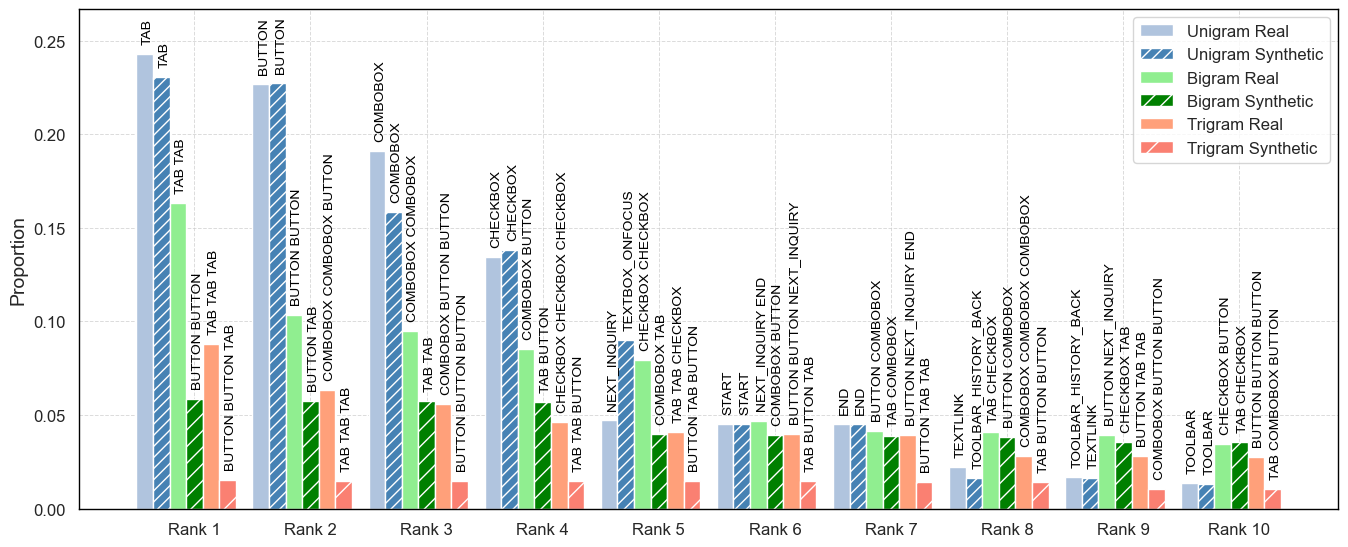

In [41]:
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from matplotlib.patches import Patch

# -----------------------
# Parameters for plotting
# -----------------------
top_n = 10          # Number of top n-grams to display per n-gram type
bar_width = 0.5     # Width of each bar
n_types = 3         # We have three types: unigram, bigram, trigram
cluster_width = n_types * 2 * bar_width  # Each type contributes 2 bars (Real and Synthetic)
gap = 0.5           # Gap between ranking groups

# -----------------------
# Define color pairs for each n-gram setting (index 0: unigram, 1: bigram, 2: trigram)
# -----------------------
color_pairs = {
    0: {"real": "lightsteelblue", "synthetic": "steelblue"},
    1: {"real": "lightgreen",    "synthetic": "green"},
    2: {"real": "lightsalmon",   "synthetic": "salmon"}
}

hatch_pairs = {
    0: {"real": "", "synthetic": "///"},
    1: {"real": "", "synthetic": "//"},
    2: {"real": "", "synthetic": "/"}
}

# -----------------------
# Precompute data for each n-gram type
# -----------------------
# We'll store the top counts and labels for real and synthetic data for n = 1,2,3.
data = {}
for n in [1, 2, 3]:
    # Extract n-grams from the real and synthetic data
    real_ngrams = extract_ngrams(df_wide_original['ActionSequence'], n=n)
    synthetic_ngrams = extract_ngrams(sd_back['ActionSequence'], n=n)
    
    # Normalize the n-gram frequencies
    real_ngrams_norm = normalize(real_ngrams)
    synthetic_ngrams_norm = normalize(synthetic_ngrams)
    
    # Get top N n-grams (most common)
    real_top = Counter(real_ngrams_norm).most_common(top_n)
    synthetic_top = Counter(synthetic_ngrams_norm).most_common(top_n)
    
    # Convert tuple n-grams to string labels for plotting
    labels_real = [' '.join(ngram) for ngram, count in real_top]
    counts_real = [count for ngram, count in real_top]
    
    labels_synth = [' '.join(ngram) for ngram, count in synthetic_top]
    counts_synth = [count for ngram, count in synthetic_top]
    
    data[n] = {
        'labels_real': labels_real,
        'counts_real': counts_real,
        'labels_synth': labels_synth,
        'counts_synth': counts_synth
    }

# -----------------------
# Determine y-axis maximum (for consistent scaling) and text offset
# -----------------------
all_counts = []
for n in [1, 2, 3]:
    all_counts.extend(data[n]['counts_real'])
    all_counts.extend(data[n]['counts_synth'])
ymax = max(all_counts) * 1.1
offset = ymax * 0.02  # Vertical offset for text labels

# -----------------------
# Create the figure and axis
# -----------------------
fig, ax = plt.subplots(figsize=(14, 6))

# Compute group (ranking) centers.
# We have top_n groups; each group will host a cluster of 6 bars.
group_centers = []
for i in range(top_n):
    # The group starts at i*(cluster_width + gap) and has width = cluster_width;
    # take the center as:
    group_center = i * (cluster_width + gap) + (cluster_width + gap) / 2
    group_centers.append(group_center)

# -----------------------
# Plot bars for each ranking group and each n-gram type
# -----------------------
# Order the n-gram types as: 1 (unigrams), 2 (bigrams), 3 (trigrams)
for i in range(top_n):
    group_center = group_centers[i]
    # For each n-gram type j (0: unigram, 1: bigram, 2: trigram)
    for j, n in enumerate([1, 2, 3]):
        # Compute the starting x-position for this n-gram type within the group
        # The cluster has total width = cluster_width; we start at the left edge:
        slot_start = group_center - cluster_width / 2 + j * (2 * bar_width)
        
        # Select the color pair for this setting
        real_color = color_pairs[j]["real"]
        synth_color = color_pairs[j]["synthetic"]
        
        # --- Real Data Bar ---
        pos_real = slot_start  # left half of the slot
        height_real = data[n]['counts_real'][i]
        ax.bar(pos_real, height_real, width=bar_width, color=real_color)
        ax.text(pos_real+ bar_width/5, height_real + offset, data[n]['labels_real'][i], # + bar_width/4
                ha='center', va='bottom', rotation=90, fontsize=10,
                color='black' 
                #fontweight='bold'
                )
        
        # --- Synthetic Data Bar ---
        pos_synth = slot_start + bar_width  # right half of the slot
        height_synth = data[n]['counts_synth'][i]
        ax.bar(pos_synth, height_synth, width=bar_width, color=synth_color, hatch=hatch_pairs[j]["synthetic"])
        ax.text(pos_synth +bar_width/5, height_synth + offset, data[n]['labels_synth'][i],
                ha='center', va='bottom', rotation=90, fontsize=10,
                color='black' 
                #fontweight='bold'
                )

# -----------------------
# Finalize the plot: x-axis, grid, legend, etc.
# -----------------------
# Set x-axis ticks at the center of each ranking group and label them by rank.
ax.set_xticks(group_centers)
ax.set_xticklabels([f"Rank {i+1}" for i in range(top_n)], fontsize=12)
ax.tick_params(axis='y', labelsize=12)


ax.set_ylim(0, ymax)
ax.set_ylabel("Proportion", fontsize=14)
# ax.set_xlabel("Ranking of N-grams (Aggregated over Unigrams, Bigrams, Trigrams)", fontsize=14)
ax.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)

# Create custom legend handles for each n-gram type and data type
legend_handles = [
    Patch(facecolor=color_pairs[0]["real"], label="Unigram Real"),
    Patch(facecolor=color_pairs[0]["synthetic"], hatch='///', label="Unigram Synthetic"),
    Patch(facecolor=color_pairs[1]["real"], label="Bigram Real"),
    Patch(facecolor=color_pairs[1]["synthetic"], hatch='//', label="Bigram Synthetic"),
    Patch(facecolor=color_pairs[2]["real"], label="Trigram Real"),
    Patch(facecolor=color_pairs[2]["synthetic"], hatch='/', label="Trigram Synthetic")
]
ax.legend(handles=legend_handles, fontsize=12)

# Add a black frame around the plot
for spine in ax.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(1.0)

plt.tight_layout()

# Save the figure if needed
if save_or_not:
    plt.savefig("../03_outputs/CPAR_top_ngrams.png", dpi=600, bbox_inches='tight')

plt.show()


### 3.5 Check actions using ROGUE_N

In [111]:
from scipy.stats import wasserstein_distance

# Function to compute unigram and bigram distributions
def compute_ngram_distribution(sequences, n=1):
    from collections import Counter
    from nltk import ngrams
    ngram_list = []
    for seq in sequences:
        tokens = seq.split(',')
        tokens = [token.strip() for token in tokens]
        ngram_list.extend(list(ngrams(tokens, n)))
    total = sum(Counter(ngram_list).values())
    return {ng: count / total for ng, count in Counter(ngram_list).items()}

# Compute JSD for N-grams
def compute_jsd(real_dist, synthetic_dist):
    all_keys = set(real_dist.keys()).union(synthetic_dist.keys())
    real_values = [real_dist.get(key, 0) for key in all_keys]
    synthetic_values = [synthetic_dist.get(key, 0) for key in all_keys]
    return jensenshannon(real_values, synthetic_values)

# Function to compute N-gram counts
def compute_ngram_counts(sequences, n):
    ngram_list = []
    for sequence in sequences:
        tokens = sequence.split(',')  # Tokenize sequence
        tokens = [token.strip() for token in tokens]  # Remove spaces
        ngram_list.extend(list(ngrams(tokens, n)))  # Generate N-grams
    return Counter(ngram_list)

# Function to return Ngram
def get_ngram_list(sequences, n):
    ngram_list = []
    for sequence in sequences:
        tokens = sequence.split(',')  # Tokenize sequence
        tokens = [token.strip() for token in tokens]  # Remove spaces
        ngram_list.extend(list(ngrams(tokens, n)))  # Generate N-grams
    return ngram_list

# Calculate ROGUE-N Precision
def calculate_rogue_precision(real_ngrams, synthetic_ngrams):
    # Count matching N-grams (intersection of real and synthetic N-grams)
    matching_ngrams = set(real_ngrams.keys()) & set(synthetic_ngrams.keys())
    matching_count = sum(synthetic_ngrams[ng] for ng in matching_ngrams)

    # Total N-grams in synthetic data
    total_synthetic_count = sum(synthetic_ngrams.values())

    # Precision calculation
    return matching_count / total_synthetic_count if total_synthetic_count > 0 else 0

# Calculate ROGUE-N Recall
def calculate_rogue_recall(real_ngrams, synthetic_ngrams):
    # Count matching N-grams (intersection of real and synthetic N-grams)
    matching_ngrams = set(real_ngrams.keys()) & set(synthetic_ngrams.keys())
    # PAN: note here for Recall you should use real_ngrams
    matching_count = sum(real_ngrams[ng] for ng in matching_ngrams)

    # Total N-grams in synthetic data
    total_real_count = sum(real_ngrams.values())

    # Precision calculation
    return matching_count / total_real_count if total_real_count > 0 else 0

# Real and synthetic sequences
real_sequences = df_wide_original['ActionSequence']
synthetic_sequences = sd_back['ActionSequence']

# Compute N-gram counts for unigrams, bigrams, and trigrams
real_unigrams = compute_ngram_counts(real_sequences, n=1)
synthetic_unigrams = compute_ngram_counts(synthetic_sequences, n=1)
rogue_1_precision = calculate_rogue_precision(real_unigrams, synthetic_unigrams)
rogue_1_recall = calculate_rogue_recall(real_unigrams, synthetic_unigrams)

real_bigrams = compute_ngram_counts(real_sequences, n=2)
synthetic_bigrams = compute_ngram_counts(synthetic_sequences, n=2)
rogue_2_precision = calculate_rogue_precision(real_bigrams, synthetic_bigrams)
rogue_2_recall = calculate_rogue_recall(real_bigrams, synthetic_bigrams)

real_trigrams = compute_ngram_counts(real_sequences, n=3)
synthetic_trigrams = compute_ngram_counts(synthetic_sequences, n=3)
rogue_3_precision = calculate_rogue_precision(real_trigrams, synthetic_trigrams)
rogue_3_recall = calculate_rogue_recall(real_trigrams, synthetic_trigrams)


# Extract distributions
real_unigram_dist = compute_ngram_distribution(real_sequences, n=1)
synthetic_unigram_dist = compute_ngram_distribution(synthetic_sequences, n=1)
rogue_1 = compute_jsd(real_unigram_dist, synthetic_unigram_dist)


real_bigram_dist = compute_ngram_distribution(real_sequences, n=2)
synthetic_bigram_dist = compute_ngram_distribution(synthetic_sequences, n=2)
rogue_2 = compute_jsd(real_bigram_dist, synthetic_bigram_dist)

real_trigram_dist = compute_ngram_distribution(real_sequences, n=3)
synthetic_trigram_dist = compute_ngram_distribution(synthetic_sequences, n=3)
rogue_3 = compute_jsd(real_trigram_dist, synthetic_trigram_dist)


In [112]:
# get the unigram, bigram, and trigram list
real_unigram_list = get_ngram_list(real_sequences, n=1)
synthetic_unigram_list = get_ngram_list(synthetic_sequences, n=1)

real_bigram_list = get_ngram_list(real_sequences, n=2)
synthetic_bigram_list = get_ngram_list(synthetic_sequences, n=2)

real_trigram_list = get_ngram_list(real_sequences, n=3)
synthetic_trigram_list = get_ngram_list(synthetic_sequences, n=3)

# get the TVComplement score
tv_unigram = TVComplement.compute(real_data = real_unigram_list, synthetic_data = synthetic_unigram_list)
tv_bigram = TVComplement.compute(real_data = real_bigram_list, synthetic_data = synthetic_bigram_list)
tv_trigram = TVComplement.compute(real_data = real_trigram_list, synthetic_data = synthetic_trigram_list)

tv_unigram, tv_bigram, tv_trigram

(0.8989543623052471, 0.507651830127533, 0.3209138301173067)

In [113]:
# Convert distributions to aligned lists
def align_distributions(real_dist, synthetic_dist):
    all_keys = set(real_dist.keys()).union(synthetic_dist.keys())
    real_values = [real_dist.get(key, 0) for key in all_keys]
    synthetic_values = [synthetic_dist.get(key, 0) for key in all_keys]
    return real_values, synthetic_values

# Compute Jensen-Shannon Divergence
unigram_real, unigram_synthetic = align_distributions(real_unigram_dist, synthetic_unigram_dist)
bigram_real, bigram_synthetic = align_distributions(real_bigram_dist, synthetic_bigram_dist)

unigram_jsd = jensenshannon(unigram_real, unigram_synthetic)
bigram_jsd = jensenshannon(bigram_real, bigram_synthetic)

# Compute Wasserstein Distance for sequence lengths
real_lengths = df_wide_original['ActionSequence'].apply(lambda x: len(x.split(','))).values
synthetic_lengths = sd_back['ActionSequence'].apply(lambda x: len(x.split(','))).values
length_wd = wasserstein_distance(real_lengths, synthetic_lengths)

print(f"Unigram JSD: {unigram_jsd}")
print(f"Bigram JSD: {bigram_jsd}")
print(f"Sequence Length Wasserstein Distance: {length_wd}")

print(f"ROGUE-1: {rogue_1}")
print(f"ROGUE-2: {rogue_2}")
print(f"ROGUE-3: {rogue_3}")

print(f"ROGUE-1 Precision: {rogue_1_precision}")
print(f"ROGUE-2 Precision: {rogue_2_precision}")
print(f"ROGUE-3 Precision: {rogue_3_precision}")

print(f"ROGUE-1 Recall: {rogue_1_recall}")
print(f"ROGUE-2 Recall: {rogue_2_recall}")
print(f"ROGUE-3 Recall: {rogue_3_recall}")

Unigram JSD: 0.21377339495238315
Bigram JSD: 0.46079384659322664
Sequence Length Wasserstein Distance: 7.678716897052905
ROGUE-1: 0.21377339495238315
ROGUE-2: 0.46079384659322664
ROGUE-3: 0.5905221555821506
ROGUE-1 Precision: 0.996927824733096
ROGUE-2 Precision: 0.8301716482012608
ROGUE-3 Precision: 0.61306885907271
ROGUE-1 Recall: 0.9975292190666556
ROGUE-2 Recall: 0.9921352561493284
ROGUE-3 Recall: 0.956755272072512
